<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/wandb_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

# How to use Mask RCNN

## Installing IceVision

We ussually install IceVision with `[all]`, but we can also use `[inference]` to install only the packages that inference methods depend on.

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

In [ ]:
# Restart kernel after installation
exit()

## Imports

In [3]:
from icevision.all import *
from fastai.callback.wandb import *
from fastai.callback.tracker import SaveModelCallback

## Data

We'll be using the [Penn-Fudan](https://www.cis.upenn.edu/~jshi/ped_html/) dataset, which is already available under `datasets`.

In [4]:
data_dir = icedata.pennfudan.load_data()
class_map = icedata.pennfudan.class_map()

As usual, let's create the parser and perfom a random data split.

In [5]:
parser = icedata.pennfudan.parser(data_dir)

train_records, valid_records = parser.parse()

INFO     - Autofixing records | icevision.parsers.parser:parse:124


In [6]:
train_records[0]["masks"]

<EncodedRLEs with 1 objects>

Let's use the usual `aug_tfms` for training transforms with two small modifications:
- Decrease the rotation limit from 45 to 10.
- Use a more aggresive crop function.

In [7]:
shift_scale_rotate = tfms.A.ShiftScaleRotate(rotate_limit=10)
crop_fn = partial(tfms.A.RandomSizedCrop, min_max_height=(384//2, 384), p=.5)
train_tfms = tfms.A.Adapter(
    [
        *tfms.A.aug_tfms(size=384, presize=512, shift_scale_rotate=shift_scale_rotate, crop_fn=crop_fn),
        tfms.A.Normalize(),
    ]
)

And for validation transforms, the simple `resize_and_pad`.

In [8]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=348), tfms.A.Normalize()])

Now we can create the `Dataset` and take a look on how the images look after the transforms.

In [9]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

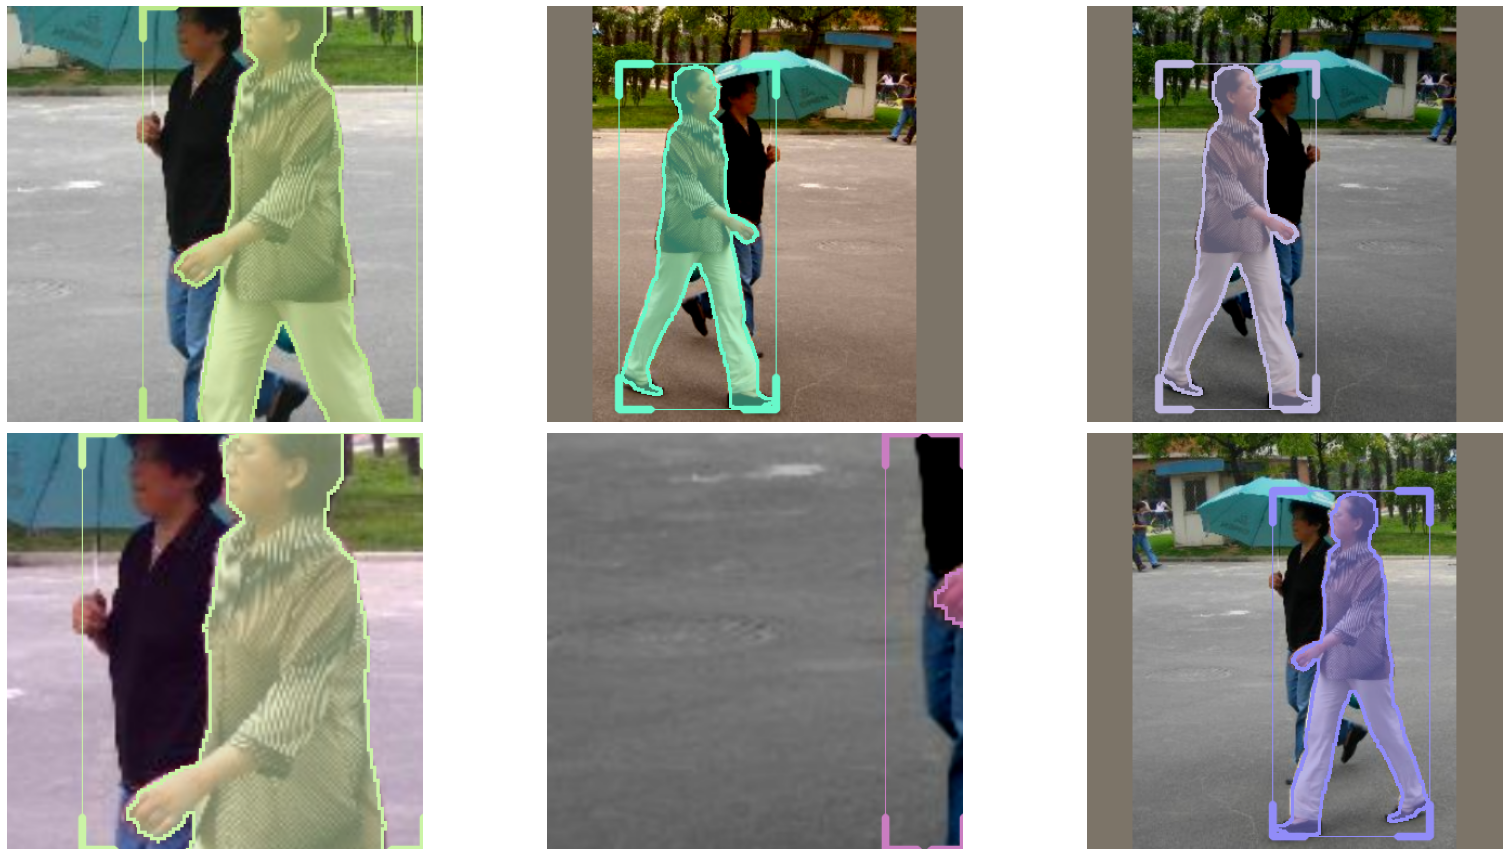

In [79]:
samples = [train_ds[2] for _ in range(6)]
show_samples(samples, denormalize_fn=denormalize_imagenet, ncols=3, display_label=False, show=True)

Now we're ready to create the DataLoaders:

In [11]:
train_dl = mask_rcnn.train_dl(train_ds, batch_size=16, shuffle=True, num_workers=4)
valid_dl = mask_rcnn.valid_dl(valid_ds, batch_size=16, shuffle=False, num_workers=4)

## Metrics

Metrics are a work in progress for Mask RCNN.

In [12]:
# metrics = [COCOMetric(COCOMetricType.mask)]

## Model

Similarly to `faster_rcnn`, we just need the `num_classes` to create a Mask RCNN model.

In [13]:
model = mask_rcnn.model(num_classes=len(class_map))

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [75]:
wandb.init(project="icevision-masks", name="mask-rcnn-resnet50-2", reinit=True)

epoch,12
train_loss,0.38875
raw_loss,0.38006
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.94994
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▆▅▄▄▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▆▃▃▂▂▅▂▁▁▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▃▄▅▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,██▇▅▄▂▁██▇▆▅▄▃▂▁▁▁▁▁▁▂▂▂▃▃▄▄▄▅▅▆▆▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▃▄▅▇█▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## Training - fastai

We just need to create the learner and fine-tune.

!!! info "Optional"  
    You can use `learn.lr_find()` for finding a good learning rate.

In [15]:
learn = mask_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, cbs=[WandbCallback(log_dataset=True, log_model=True), SaveModelCallback()])

WARNING  - Wandb quickfix implemented, for more info check issue #527 | icevision.models.rcnn.fastai.learner:rcnn_learner:39


In [16]:
# !cp /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth models/

In [17]:
# !ls models

In [18]:
# !rm models/model.pth

In [19]:
learn.fine_tune(10, 5e-4, freeze_epochs=2)

Could not gather input dimensions
WandbCallback could not retrieve the dataset path, please provide it explicitly to "log_dataset"
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,time
0,1.843482,0.828755,00:13
1,1.284275,0.588426,00:10


Better model found at epoch 0 with valid_loss value: 0.828754723072052.
Better model found at epoch 1 with valid_loss value: 0.5884255766868591.


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")
wandb: Adding directory to artifact (/tmp/tmpgcqxjvrk)... Done. 0.4s


Could not gather input dimensions


epoch,train_loss,valid_loss,time
0,0.591160,0.429428,00:14
1,0.529282,0.374389,00:12
2,0.500065,0.406371,00:10
3,0.480722,0.368016,00:11
4,0.465826,0.340654,00:11
5,0.446898,0.317662,00:12
6,0.429577,0.323954,00:11
7,0.417124,0.314693,00:11
8,0.405281,0.313216,00:11
9,0.388749,0.316623,00:11


Exception ignored in: <finalize object at 0x7fdfac6a4190; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.6/weakref.py", line 548, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/usr/lib/python3.6/tempfile.py", line 938, in _cleanup
    _rmtree(name)
  File "/usr/lib/python3.6/shutil.py", line 477, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 475, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpgcqxjvrk'


Better model found at epoch 0 with valid_loss value: 0.42942774295806885.
Better model found at epoch 1 with valid_loss value: 0.37438860535621643.
Better model found at epoch 3 with valid_loss value: 0.36801600456237793.
Better model found at epoch 4 with valid_loss value: 0.3406542241573334.
Better model found at epoch 5 with valid_loss value: 0.31766191124916077.
Better model found at epoch 7 with valid_loss value: 0.314692884683609.
Better model found at epoch 8 with valid_loss value: 0.3132163882255554.


wandb: Adding directory to artifact (/tmp/tmpf05n03p9)... Done. 0.4s


## Visualize predictions

Let's grab some images from `valid_ds` to visualize. For more info on how to do inference, check the [inference tutorial](https://airctic.github.io/icevision/inference/).

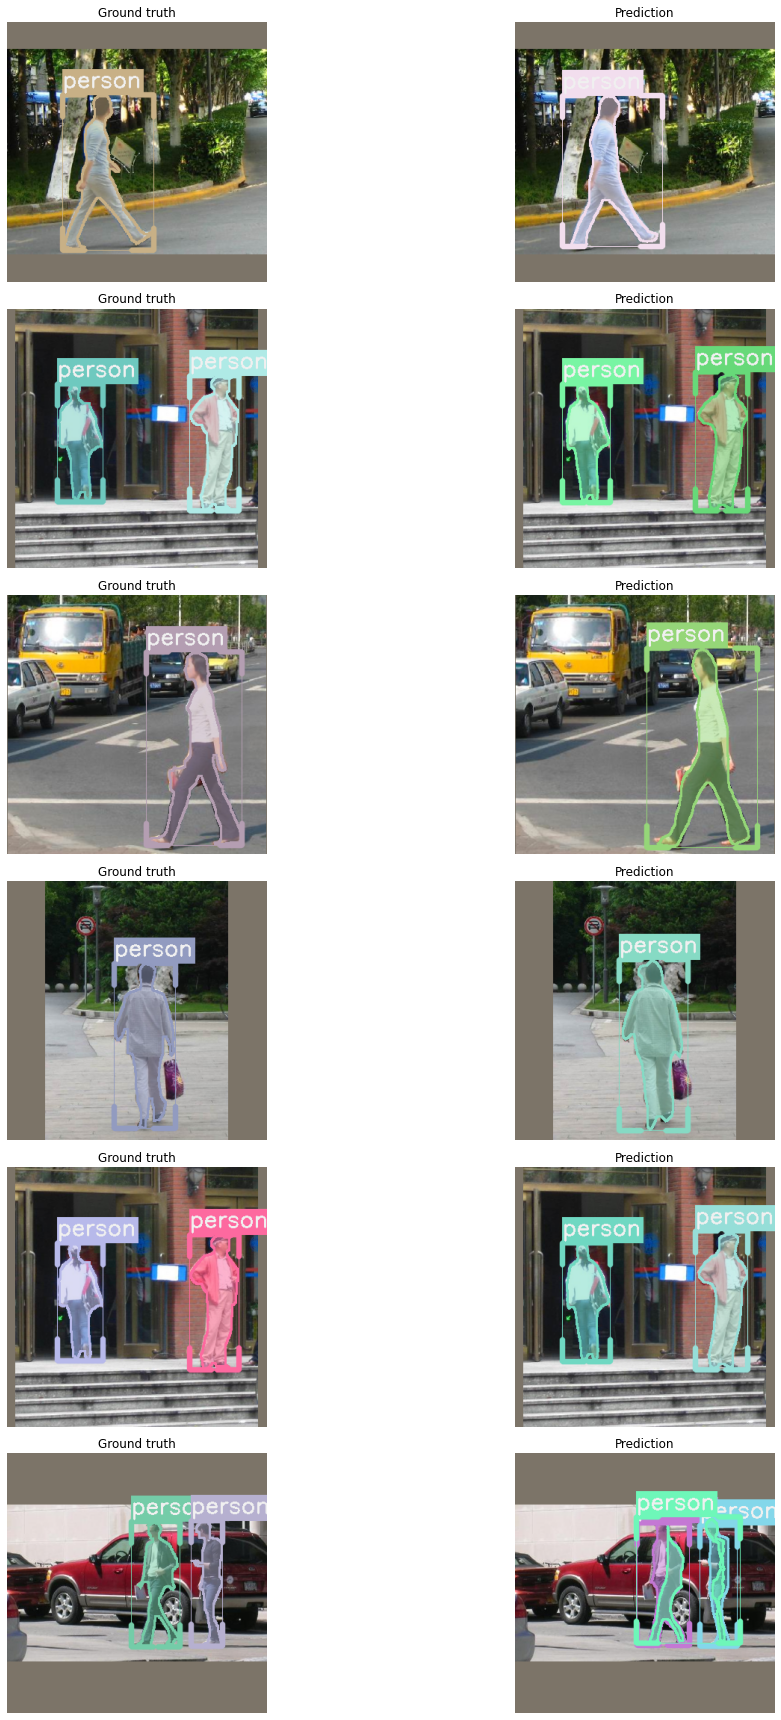

In [30]:
mask_rcnn.show_results(model, valid_ds, class_map=class_map)

In [31]:
infer_dl = mask_rcnn.infer_dl(valid_ds, batch_size=8)
samples, preds = mask_rcnn.predict_from_dl(model=model, infer_dl=infer_dl)

In [72]:
wandb_images = wandb_img_preds(samples, preds, class_map, add_ground_truth=True) 

In [73]:
len(wandb_images)

34

In [76]:
wandb.log({"Predicted images": wandb_images})

In [ ]:
wandb.join()

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).